<a href="https://colab.research.google.com/github/abhis24/DataMining_Fall23/blob/main/DM_572_HW2_task1_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


In [114]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [115]:
# Using 'copy()' to clone the dataset
train_OG = train.copy()

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Is_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Is_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# New features
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Impute features by replacing the Null data
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

for dataset in data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

for dataset in data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Mapping
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    dataset.loc[ dataset['Fare'] <= 8, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 8) & (dataset['Fare'] <= 15), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 15) & (dataset['Fare'] <= 30), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 30, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset.loc[ dataset['Age'] <= 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 30), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 50), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 70), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 70, 'Age'] = 4 ;

In [116]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

# Decision Tree

In [ ]:
cv = KFold(n_splits=5)
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)

    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                               y = f_train["Survived"])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies}, columns = ["Max Depth", "Average Accuracy"])
df

In [126]:
cv = KFold(n_splits=5)
fold_accuracy = []
tree_model = tree.DecisionTreeClassifier(max_depth = 4)
# print("Current max depth: ", depth, "\n")
for train_fold, valid_fold in cv.split(train):
    f_train = train.loc[train_fold] # Extract train data with cv indices
    f_valid = train.loc[valid_fold] # Extract valid data with cv indices

    model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                           y = f_train["Survived"]) # We fit the model with the fold train data
    valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                            y = f_valid["Survived"])# We calculate accuracy with the fold validation data
    fold_accuracy.append(valid_acc)

# print("Accuracies of all folds:", fold_accuracy)
avg = sum(fold_accuracy)/len(fold_accuracy)
print("Average Accuracy: {}".format(round(avg*100, 3)))

Average Accuracy: 81.031


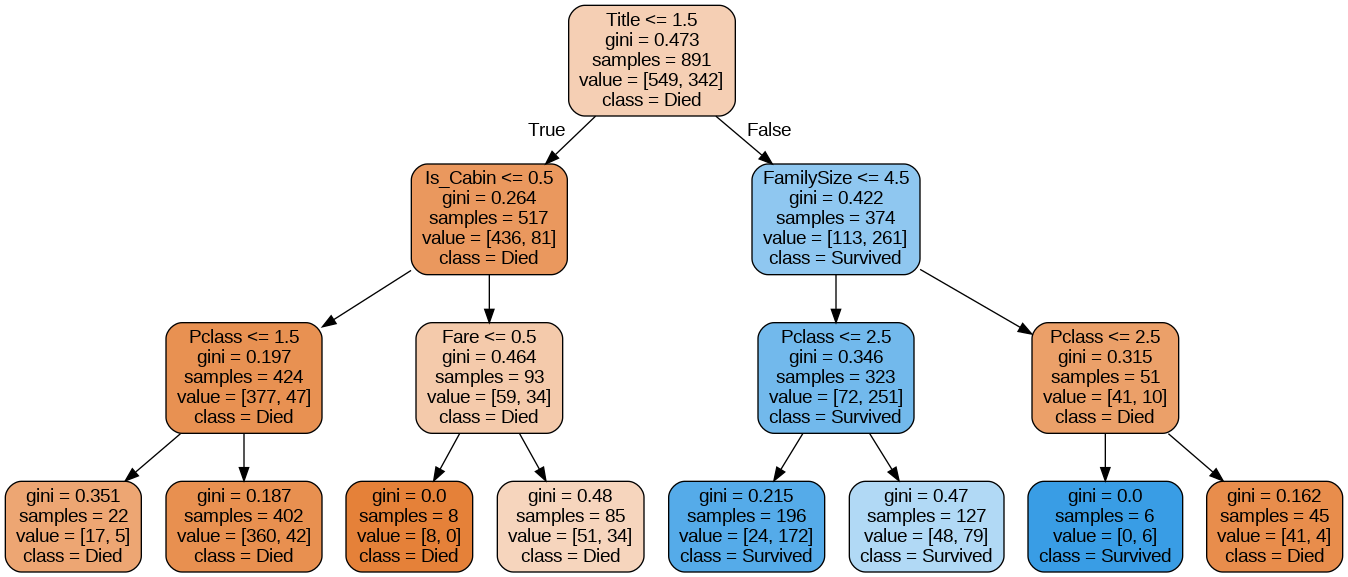

In [124]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )

#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png")

# Random Forest

In [120]:
cv = KFold(n_splits=5)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = RandomForestClassifier(max_depth = depth, n_estimators=50)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")

# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.786724
         2          0.808066
         3          0.824901
         4          0.828253
         5          0.829389
         6          0.810307
         7          0.812567
         8          0.819302
         9          0.811449
        10          0.814820


In [125]:
cv = KFold(n_splits=5)
fold_accuracy = []
tree_model = RandomForestClassifier(max_depth = 3, n_estimators=20)
# print("Current max depth: ", depth, "\n")
for train_fold, valid_fold in cv.split(train):
    f_train = train.loc[train_fold] # Extract train data with cv indices
    f_valid = train.loc[valid_fold] # Extract valid data with cv indices

    model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                           y = f_train["Survived"]) # We fit the model with the fold train data
    valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                            y = f_valid["Survived"])# We calculate accuracy with the fold validation data
    fold_accuracy.append(valid_acc)

print("Accuracies of all folds:", fold_accuracy)
avg = sum(fold_accuracy)/len(fold_accuracy)
print("Average Accuracy: {} %".format(round(avg*100, 3)))

Accuracies of all folds: [0.8435754189944135, 0.8202247191011236, 0.8202247191011236, 0.7865168539325843, 0.8314606741573034]
Average Accuracy: 82.04 %
